In [1]:
import pandas as pd
import numpy as np
import time
from matplotlib import pyplot as plt
import datetime as dt
from zigzag_dag26 import zigzag
import talib
from tqdm import tqdm
import colorama as col

In [2]:
%%time
##### Chargement de la base
base = pd.read_csv('Base_Clean/EURUSDm15.csv')

##### On fixe la date en index sous forme de Timestamp
base.set_index(pd.to_datetime(base.Date),drop=True,inplace=True)

###### On drop les colonnes inutiles
base = base.drop(['Date','Total'],axis=1)

##### On enlève les jours correspondant au samedi et au dimanche
base['WE'] = np.where(((base.index.weekday == 5) | (base.index.weekday == 6)),None,base.index.weekday)
base = base.dropna()
base = base.drop(['WE'],axis=1)


CPU times: user 645 ms, sys: 99 ms, total: 744 ms
Wall time: 749 ms


In [3]:
base.index[0],base.index[-1]

(Timestamp('2010-11-23 00:00:00'), Timestamp('2020-11-23 23:45:00'))

In [16]:
%%time
_year_bottom = pd.to_datetime('2019-11-23 16:00:00')
_year_top = pd.to_datetime('2020-11-23 16:00:00') #2020-11-23 16:00:00

df = base[(base.index>=_year_bottom)&(base.index<=_year_top)]

df_input = df.copy()

df_bt = df.copy()

df.head()

CPU times: user 6.33 ms, sys: 4.07 ms, total: 10.4 ms
Wall time: 8.84 ms


,OpenBid,HighBid,LowBid,CloseBid,OpenAsk,HighAsk,LowAsk,CloseAsk,Open,High,Low,Close
Date,,,,,,,,,,,,
2019-11-25 00:00:00,1.10149,1.10196,1.10149,1.10193,1.10200,1.10216,1.10182,1.10212,1.101745,1.102060,1.101655,1.102025
2019-11-25 00:15:00,1.10193,1.10207,1.10187,1.10199,1.10212,1.10228,1.10203,1.10223,1.102025,1.102175,1.101950,1.102110
2019-11-25 00:30:00,1.10199,1.10209,1.10197,1.10205,1.10223,1.10225,1.10214,1.10223,1.102110,1.102170,1.102055,1.102140
2019-11-25 00:45:00,1.10205,1.10216,1.10205,1.10214,1.10223,1.10231,1.10221,1.10228,1.102140,1.102235,1.102130,1.102210
2019-11-25 01:00:00,1.10214,1.10215,1.10207,1.10207,1.10228,1.10228,1.10219,1.10220,1.102210,1.102215,1.102130,1.102135


In [17]:
_deviation = 0.001
_backstep = 6 # 3
_depth = 50 # 10
df.shape

(24603, 12)

100%|██████████| 24603/24603 [00:07<00:00, 3331.43it/s]
Il y a  213 signaux VALLEY,  212 signaux PEAK, et  24178  signaux sans rien
CPU times: user 7.71 s, sys: 154 ms, total: 7.86 s
Wall time: 7.71 s


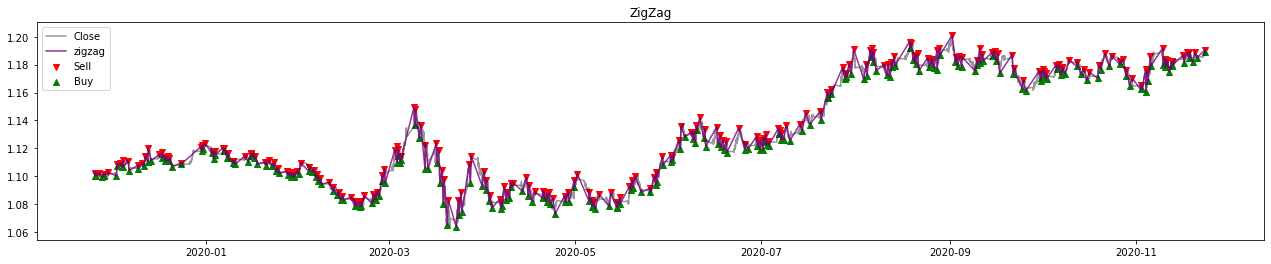

In [18]:
%%time
PEAK,VALLEY = zigzag(df,_deviation, _backstep, _depth)
df['BackHi_pic'] = PEAK
df['BackLo_val'] = VALLEY
#df['BackHi'] = np.where(df.High == df.High.rolling(_backstep).max(),df.High,0)
#df['BackLo'] = np.where(df.Low == df.Low.rolling(_backstep).min(),df.Low,0)

In [21]:
from retracement import ret_hilo
df = ret_hilo(df,0.618,0.01,0,0)

100%|██████████| 24603/24603 [00:02<00:00, 11707.82it/s]


In [22]:
df['Signal'] = np.where(
                            df.BuyRet == 1,1,np.where(
                                                        df.SellRet == 1,-1,0
                            )
)

In [23]:
from bt import bt

In [36]:
_nb_bougie_exit = 60
_trigger_reengage = 0
_trigger_target = 1
_trigger_invers = 0
_trigger_sl = 0
_verbose = 0
_cash_ini = 200000
_rate = 1
x = 'EUR/USD'
_target = 0.05
_exposure = 10
_size = 50000
_sl = 0.004

In [37]:
bt(df,_year_bottom,_year_top,_nb_bougie_exit,_trigger_reengage,_trigger_target,_trigger_invers,_trigger_sl,_verbose,_cash_ini,\
        _rate,x,_target,_exposure,_size,_sl)

Librairies imported

Début des opérations horodatée à 2020-12-08 22:06:52.339851

Chargement de la nouvelle base


 Le rate du ticker EUR/USD est à  1 
Bases chargées
TETEL process effectué
 ENTERING THE BACKTEST 
100%|██████████| 24603/24603 [00:02<00:00, 9241.51it/s]
 Pour le ticker  EUR/USD 
 
Les gains faramineux s'élèvent à : $  -12002.0 !. En  191   transactions.
 
Nbre de winners : 63 
 
Nbre de loosers : 127 
Temps d'excution du BT 0:00:08.908605
 EUR/USD  results 
 Tested Period 2019-11-23 16:00:00  à 2020-11-23 16:00:00 
 Total Number of trades 191 
Started Cash : 50000
P&L in currency:  -12002.0$ 
P&L in %:  -6.0% 
Average trade duration 60.0
# Winners  63.0
# Loosers  127.0
Cumulated gains 7098.0
Cumulated losses -19100.0
 PROFIT FACTOR :  0.37 
 Winners Ratio : 33.16 % 
Average Winners 37.16
Average Loosers -100.0
Average pnl -62.84
% Average Winners 0.02
% Average Loosers -0.05
% Average pnl -0.03
Number of opened trades 191
Number of closed trades 190
Max Exposure 1 x  5

()

In [13]:
from vanilla_bt import *
from scipy.ndimage.interpolation import shift

In [14]:
%time
df.Signal = np.where(df.BuyRet == 1,1,np.where(df.SellRet==1,-1,0))
#df.Signal = shift(df.Signal,-1,cval=np.NaN)
bt_tpsl(df,0.05,0.004)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs
fermeture long en l'air
Winner Ratio : -600.0 %
Profit Factor :  0.19 % 
 Période du 2020-10-23 16:00:00 au  2020-11-23 16:00:00 
Nombre de trades : 8
Nombre de posistions non fermées 0
Captital initial : 250000
Taille des positions : 50000
Gain :  -1449.0000000000223 
Capital Final : 248550.99999999997


()

In [ ]:
##############
#### GRID ####
##############

In [15]:
%%time
df.Signal = np.where(df.BuyRet == 1,1,np.where(df.SellRet==1,-1,0))
bt_tpsl_grid(df)

Pour un TP de   0.1  et un SL de   0.1 
fermeture long en l'air
Winner Ratio : 100.0 %
Profit Factor :  inf % 
Nombre de trades : 1
Nombre de posistions non fermées 0
Captital initial : 250000
Taille des positions : 50000
Gain :  423.9999999999911 
Capital Final : 250424.0

________________________________________________________________________________________

Pour un TP de   0.1  et un SL de   0.09 
fermeture long en l'air
Winner Ratio : 100.0 %
Profit Factor :  inf % 
Nombre de trades : 1
Nombre de posistions non fermées 0
Captital initial : 250000
Taille des positions : 50000
Gain :  423.9999999999911 
Capital Final : 250424.0

________________________________________________________________________________________

Pour un TP de   0.1  et un SL de   0.08 
fermeture long en l'air
Winner Ratio : 100.0 %
Profit Factor :  inf % 
Nombre de trades : 1
Nombre de posistions non fermées 0
Captital initial : 250000
Taille des positions : 50000
Gain :  423.9999999999911 
Capital Final : 250

KeyboardInterrupt: 

In [7]:
_fibo = 0.618
_err = 0.01

In [37]:
%%time
LASTP1 = []
LASTV1 = []
LASTP2 = []
LASTV2 = []
lastv1 = 0
lastp1 = 0
lastv2 = 0
lastp2 = 0
lastp = 0
lastv = 0

for i in tqdm(range(len(df))):
    if df.BackLo_val[i] == 1:
        lastv2 = lastv1
        #lastv1 = lastv
        lastv1 = df.Low[i]
        LASTV1.append(lastv1)
        LASTP1.append(lastp1)
        LASTV2.append(lastv2)
        LASTP2.append(lastp2)
    elif df.BackHi_pic[i] == 1:
        lastp2 = lastp1
        #lastp1 = lastp
        lastp1 = df.High[i]
        LASTP1.append(lastp1)
        LASTV1.append(lastv1)
        LASTP2.append(lastp2)
        LASTV2.append(lastv2)
    else:
        LASTP1.append(lastp1)
        LASTV1.append(lastv1)
        LASTP2.append(lastp2)
        LASTV2.append(lastv2)

df['LastP1'] = LASTP1
df['LastV1'] = LASTV1
df['LastP2'] = LASTP2
df['LastV2'] = LASTV2
df['XAp'] =  df['LastV2'] -  df['LastP2']
df['XAv'] = df['LastP2'] -  df['LastV2']
df['ABp'] = df['LastP1'] -  df['LastV2']
df['ABv'] = df['LastV1'] -  df['LastP2']
df['BCp'] = df['LastV1'] -  df['LastP1']
df['BCv'] = df['LastP1'] -  df['LastV1']
df['CDp'] = df['High'] - df['LastV1']
df['CDv'] = df['Low'] - df['LastP1']

100%|██████████| 24603/24603 [00:01<00:00, 17181.60it/s]CPU times: user 1.45 s, sys: 10.5 ms, total: 1.46 s
Wall time: 1.46 s



In [38]:
#for i in range(190):
 #   print(i,' --- ',df.LastV1[i],' -------------- ' , df.LastV1[i-1],' ----- ','oui' if df.LastV1[i] == df.LastV1[i-1] else 'non')

In [39]:
#df[['BackHi_pic','BackLo_val','High','Low','LastP1','LastP2','LastV1','LastV2']].iloc[85:125,:]

In [40]:
%%time
BUY = [] 
SELL = [] 
INDEXv = []
VALUEv = []
INDEXp = []
VALUEp = []
_pic = 0
_val = 0
_picklock = 0
_locked = 1

for i in tqdm(range(0,len(df))):

    if df.BackLo_val[i] == 1:
        #print('\nVAL a 1, Initiation de recherche PIC en',i,'\n')
        #print('\nAffichage CDp',df.CDp[i],' CDv',df.CDv[i],'\n')
        _pic = 1
        _val = 0
        _locked = 0
        _picklock += 1
    elif df.BackHi_pic[i] == 1:
        #print('\nPIC a 1, Initiation de recherche VAL en',i,'\n')
        #print('\nAffichage CDp',df.CDp[i],' CDv',df.CDv[i],'\n')
        _val = 1
        _pic = 0
        _locked = 0
        _picklock += 1
    if _picklock < 4:
        _locked = 1


    if _val == 1 and _locked == 0 and abs(df.CDv[i]/df.BCv[i]) > _fibo * (1+_err) :
        #print('\n[Mode_VALLEY = ON]\nDate  :',df.index[i],'i : ',i,'\nLow : ',df.Low[i],'\nLastP : ',df.LastP1[i],'\nLastV : ',df.LastV1[i],'\nfibo*(1+err : ',_fibo * (1+_err))
        #print('\nho : ',abs(df.Low[i] - df.LastP1[i]),'\n ba : ',abs(df.LastP1[i] - df.LastV1[i]),'\nletou quessé de lunsurlotr: ',abs((df.Low[i] - df.LastP1[i]) / (df.LastP1[i] - df.LastV1[i])),'\n_____________________\n\n')
        VALUEv.append(df.Low[i])
        INDEXv.append(df.index[i])
        BUY.append(1)
        SELL.append(0)
        _val = 0
        _locked = 1

    elif _pic == 1 and _locked == 0 and abs(df.CDp[i]/df.BCp[i]) > _fibo * (1+_err): 
        #print('\n[Mode_PEAK = ON]\nDate  :',df.index[i],'i : ',i,'\nHigh : ',df.High[i],'\nLastV : ',df.LastV1[i],'\nLastP : ',df.LastP1[i],'\nfibo*(1+err : ',_fibo * (1+_err))
        #print('\nho : ',abs(df.CDp[i]),'\n ba : ',abs(df.BCp[i]),'\nletou quessé de lunsurlotr: ',abs(df.CDp[i]/df.BCp[i]),'\n_____________________\n\n')
        VALUEp.append(df.High[i])
        INDEXp.append(df.index[i])
        BUY.append(0)
        SELL.append(1)
        _pic = 0
        _locked = 1
        
    else:
        BUY.append(0)
        SELL.append(0)
    
df['BuyRet'] = BUY
df['SellRet'] = SELL

100%|██████████| 24603/24603 [00:02<00:00, 11663.35it/s]CPU times: user 2.11 s, sys: 11.8 ms, total: 2.13 s
Wall time: 2.12 s



CPU times: user 310 ms, sys: 17.9 ms, total: 328 ms
Wall time: 271 ms


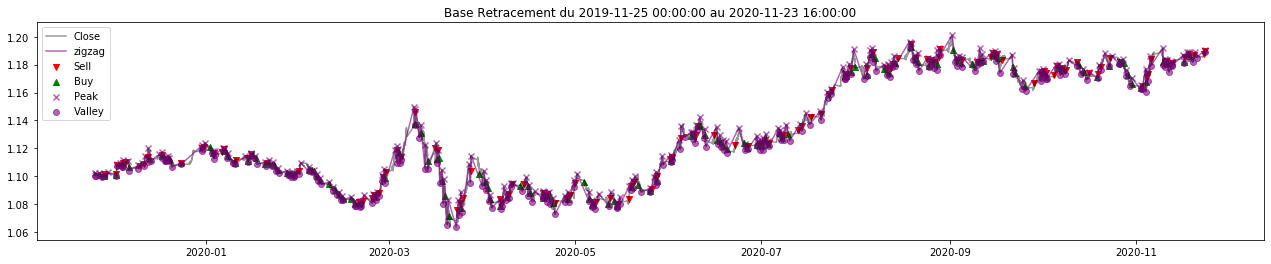

In [41]:
%%time

df_zigzag = pd.DataFrame()
df_zigzag['PeakValley'] = pd.concat([df.BackHi_pic, df.BackLo_val], axis=0, ignore_index=False, sort=True)
df_zigzag['Close'] = pd.concat([df.High, df.Low], axis=0, ignore_index=False, sort=True)
df_zigzag = df_zigzag[df_zigzag.PeakValley==1]
# Sort peak and valley datapoints by date.
df_zigzag = df_zigzag.sort_index()

plt.figure(figsize=(22,4))
plt.title('Base Retracement du '+str(df.index[0])+' au '+str(df.index[-1]))
plt.plot(df.Close,color='black',alpha=0.4,label="Close")
#plt.plot(df.High,color='orange',alpha=0.3,label="High")
#plt.plot(df.Low,color='blue',alpha=0.3,label="Low")
#plt.plot(talib.SMA(df.Close, 200),color='blue',alpha=0.6,label='SMA')


plt.scatter(x=INDEXp,y=VALUEp,color='red',marker='v',label="Sell")
plt.scatter(x=INDEXv,y=VALUEv,color='green',marker='^',label="Buy")

plt.scatter(x=df[df.BackHi_pic==1].index,y=df[df.BackHi_pic==1].High,color='purple',marker='x',label="Peak",alpha=0.6)
plt.scatter(x=df[df.BackLo_val==1].index,y=df[df.BackLo_val==1].Low,color='purple',marker='o',label="Valley",alpha=0.6)
plt.plot(df_zigzag.index.values, df_zigzag['Close'].values,color='purple', label="zigzag",alpha=0.6)
plt.legend()
#plt.savefig('pic.png',dpi=1000)
